# Image Classification Model for MNIST Handwritten Digits Using Python and AutoKeras
### David Lowe
### October 29, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The MNIST Handwritten Digits dataset is an image classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The MNIST problem is a dataset developed by Yann LeCun, Corinna Cortes, and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem. The dataset was constructed from many scanned document datasets available from the National Institute of Standards and Technology (NIST). Each image is a 28 by 28-pixel square (784 pixels total). A standard split of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model, and a separate set of 10,000 images are used to test it. It is a digit recognition task, so there are ten classes (0 to 9) to predict.

ANALYSIS: After a series of modeling trials, the AutoKeras system processed the validation dataset with an accuracy score of 94.84%. When we applied the best AutoKeras model to the previously unseen test dataset, we obtained an accuracy score of 98.4%.

CONCLUSION: In this iteration, the best TensorFlow model generated by AutoKeras appeared to be suitable for modeling this dataset. We should consider experimenting with AutoKeras for further modeling.

Dataset Used: MNIST Handwritten Digits Dataset

Dataset ML Model: Image regression modeling with numerical attributes

Dataset Reference: https://www.tensorflow.org/datasets/catalog/mnist

One potential source of performance benchmark: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

Any predictive modeling machine learning project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL boto3
!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc3
!pip install autokeras

  Cloning https://github.com/keras-team/keras-tuner.git (to revision 1.0.2rc3) to /tmp/pip-req-build-sxw4xmg6
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-sxw4xmg6
  Running command git checkout -q 172be42f1310cdbad48941494f84d65367de4f11
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2rc3-cp36-none-any.whl size=91635 sha256=fae077e420ef236f768179064494a4c5b2d959e61a0d7dcb32882fe49c650f07
  Stored in directory: /tmp/pip-ephem-wheel-cache-3k9je3al/wheels/2d/b8/84/5f9abbcad32fc56a0fdd5d1b8c267221abb5ec582dde4371f7
Successfully built keras-tuner


In [2]:
# Clean up outstanding AutoKeras working folder and files
!rm -rf image_classifier/

In [3]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Oct 25 19:13:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [6]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [7]:
# Set the random seed number for reproducible results
seedNum = 888

In [8]:
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
# import boto3
from datetime import datetime
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
import autokeras as ak

### 1.b) Set up the controlling parameters and functions

In [9]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.2

# Set the number of folds and iterations for cross validation
n_folds = 5

# Set various default modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epochs = 1
default_batch = 32
default_trials = 10

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.3.0


In [10]:
# Set up the parent directory location for loading the dotenv files
# useColab = False
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = False
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [11]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [12]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [14]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [15]:
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (60000, 28, 28) y_train.shape: (60000,)


In [16]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [17]:
if notifyStatus: status_notify('(AutoKerasImage Classification) Task 2 - Summarize and Visualize Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

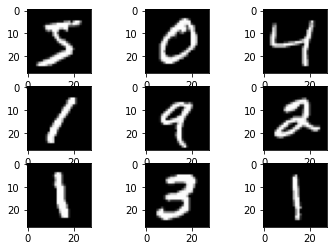

In [18]:
# Plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [19]:
print(y_train[:9])

[5 0 4 1 9 2 1 3 1]


In [20]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 2 - Summarize and Visualize Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [21]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [22]:
# Not applicable for this iteration of the modeling

In [23]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [24]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [25]:
# Perform the model search
startTimeModule = datetime.now()
ak_model = ak.ImageClassifier(loss=default_loss, metrics=default_metrics, max_trials=default_trials, seed=seedNum, overwrite=True)
ak_model.fit(X_train, y_train, epochs=default_epochs, validation_split=val_set_size, batch_size=default_batch, verbose=1)
final_model = ak_model.export_model()
print ('Model training time:', (datetime.now() - startTimeModule))

Trial 10 Complete [00h 00m 09s]
val_loss: 0.3497171700000763

Best val_loss So Far: 0.05910641327500343
Total elapsed time: 00h 26m 31s
INFO:tensorflow:Oracle triggered exit
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1762 - accuracy: 0.9484
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets
Model training time: 0:26:46.994735


In [26]:
# Summarize the final model
final_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow (None, 28, 28)            0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens (None, 28, 28, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 28, 28, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)       

In [28]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [29]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [30]:
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (10000, 28, 28) y_test.shape: (10000,)


In [31]:
test_pred = ak_model.predict(X_test, batch_size=default_batch, verbose=1)
test_predictions = [int(x) for [x] in test_pred]
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

313/313 [==============================] - 0s 1ms/step
Accuracy Score: 0.984
[[ 974    0    1    0    0    1    1    1    2    0]
 [   0 1130    2    0    0    0    1    0    2    0]
 [   2    3 1010    3    1    0    1    7    5    0]
 [   0    0    2  995    0    6    0    6    1    0]
 [   1    0    1    0  974    0    0    0    2    4]
 [   2    0    0    4    0  883    2    0    1    0]
 [   8    3    0    0    1    6  939    0    1    0]
 [   1    1   10    2    0    1    0 1009    2    2]
 [   6    0    4    3    3    3    0    5  946    4]
 [   2    3    1    2    9    4    0    7    1  980]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6 

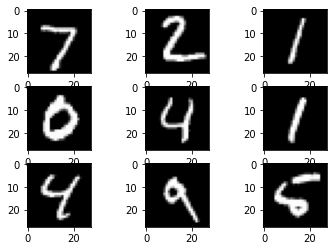

In [32]:
# Plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))
plt.show()

In [33]:
print(test_predictions[:9])

[7, 2, 1, 0, 4, 1, 4, 9, 5]


In [34]:
if notifyStatus: status_notify('(AutoKeras Image Classification) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:26:50.539490
